In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from matplotlib import animation

# Cellular Automata S.I.R. Model

### Description

Based on the reference [paper](https://www.math.uh.edu/~zpkilpat/teaching/math4309/project/physa99_fuentes.pdf), the aim of the project is to simulate and then study the evolution of Susceptible-Infected-Removed populations over space and time.

### Assignments
1. Consider a grid of a given form (squared or exagonal or whatever) and then let propagate the SIR model. 
2. Repeat point 1 several times in order to obtain several reference datasets
3. Try to predict the evolution of the epidemic both in space and time on the basis of the previous steps, e.g. by means of 
4. Define a metric on how the epidemic evolved e.g. assigning a probability for a given node not to get infected or predict the fraction of the nodes that got infected at the end of the epidemic

### Contacts
* Leonardo Badia <badia@dei.unipd.it>

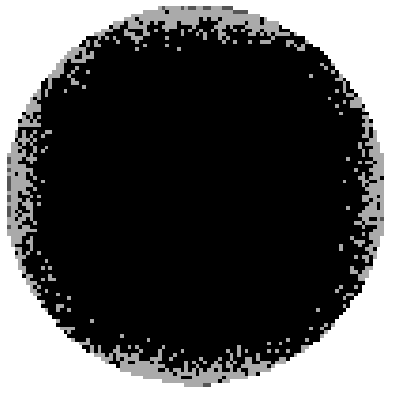

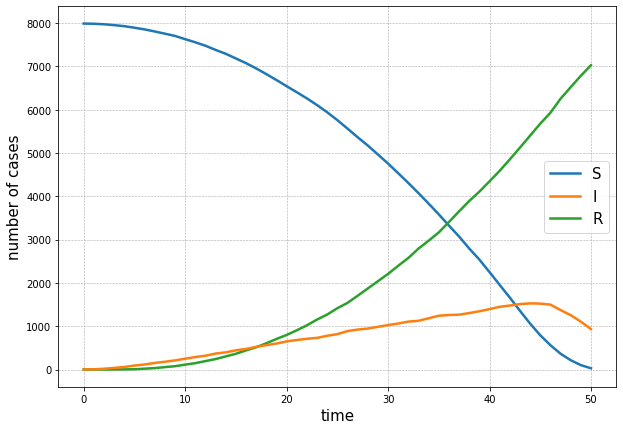

In [15]:
def draw_line(mat, point1, point2):
    
    # function that tries to draw the best possible line made of 0s between two points point1, point2
    
    x0, y0 = point1[0], point1[1];
    x1, y1 = point2[0], point2[1];
    if not (0 <= x0 < mat.shape[0] and 0 <= x1 < mat.shape[0] and
            0 <= y0 < mat.shape[1] and 0 <= y1 < mat.shape[1]):
        raise ValueError('Invalid coordinates.')
        
    if (x0, y0) == (x1, y1):
        mat[x0, y0] = 0
        return mat
    
    # Swap axes if Y slope is smaller than X slope
    transpose = abs(x1 - x0) < abs(y1 - y0)
    if transpose:
        mat = mat.T
        x0, y0, x1, y1 = y0, x0, y1, x1
        
    # Swap line direction to go left-to-right if necessary
    if x0 > x1:
        x0, y0, x1, y1 = x1, y1, x0, y0
        
    # Compute intermediate coordinates using line equation
    x = np.arange(x0 + 1, x1)
    y = np.round(((y1 - y0) / (x1 - x0)) * (x - x0) + y0).astype(x.dtype)
    
    # Write intermediate coordinates
    mat[x, y] = 0

    return mat if not transpose else mat.T

    
def new_population(N, n):
    
    # function that generates a new population. A population is a matrix NxN containing 2 everywhere except
    # inside a figure of n vertices where there are all 0s.
    
    from numpy import pi, floor, ceil, cos, sin;
    
    if n < 3: raise Exception('The number of vertices must be greater than 2.');
    
    if N%2 == 0: N+=1
        
    M = np.ones((N,N), dtype=int)+1 # matrix of 2s

    center = [floor(N/2), floor(N/2)]
    radius = floor(N/2)
    angle = 2*pi/n
    
    vertices = np.zeros((n+1,2), dtype=int)
    for vertex in range(n): # for each vertex of the polygon
        x = int(floor(center[0] + radius*cos(vertex*angle))) # x coord of the vertex of the polygon
        y = int(floor(center[1] - radius*sin(vertex*angle))) # y coord of the vertex of the polygon
        M[x,y] = 0 # set to 0 the coordinate of the population matrix
        vertices[vertex] = [x,y] # list of coordinates of the vertices of the polygon
    vertices[n] = vertices[0] # add the first vertex at the end so that is a closed polygon

    for i in range(1,len(vertices)):
        M = draw_line(M, vertices[i-1], vertices[i]) # trace the edges of the polygon
            
       
    for row in range(N): # the polygon is filled with 0s for each row
        row_i = M[row,:]   
        x1 = np.argwhere(M[row,:]==0)
        x2 = np.argwhere(M[row,:]==0)
        if len(x1)==0 or len(x2)==0: continue;
        x1, x2 = min(x1), max(x2)
        if x1==0 and x2==0: continue;
        M = draw_line(M, [row, x1], [row, x2])
          
    return M;


####################################################################################################################


resolution, polygon_sides = 100, 50 # resolution is in reality the number of people inside the outward matrix
population = new_population(resolution, polygon_sides); # population is a matrix of 2 if outside the figure while 0 if inside the figure
population_time = np.zeros(population.shape)-1

center = int(np.floor(resolution/2)) # just to keep track of where the center is

# 0 = S , 1 = I , -1 = R
p_i = 0.5 # probability of infection
p_r = 0.05 # probability of recovery
infected = (center,center) # initialization of where Infected are. Can be tuple or list of tuples
population[infected]=1 # the people located at "infected" are turned into infected: 0 -> 1


fig1 = plt.figure(figsize = (7,7));
plt.axis('off');
im = plt.imshow(population, cmap='gray', vmin=-1, vmax=2, animated=True)

cycles=50 # maximum number of cycles   
images = [[im]]; S=[]; I=[]; R=[];
for cycle in range(cycles):
  s,i,r=0,0,0
  for index,value in np.ndenumerate(population):
    if population_time[index]==cycle:pass #already processed
    elif value==2:pass #not in the region space
    elif value==1: #infect detected
      i+=1
      #cicle the neighbors for infection
      for j in range(-1,2):
        for k in range(-1,2):
          if 0<=index[0]+j<population.shape[0] and 0<=index[1]+k<population.shape[1]:
            if population[index[0]+j,index[1]+k]==0 and np.random.choice([1, 0], p=[p_i, 1-p_i]): #element get infected
              population[index[0]+j,index[1]+k]=1
              population_time[index[0]+j,index[1]+k]=cycle #mark as infected in this cicle
              if j==1 or (j==0 and k==1): s+=1 #the item will not be counted otherwise
      #infected may recovers
      if np.random.choice([1, 0], p=[p_r*(cycle-population_time[index]), 1-p_r*(cycle-population_time[index])]):
        population[index]=-1
        population_time[index]=cycle
    elif value==0: s+=1
    elif value==-1: r+=1
  im = plt.imshow(population, cmap='gray', vmin=-1, vmax=2, animated=True)
  images.append([im]) # animation...
  S.append(s) # number of S in cycle
  I.append(i) # number of I in cycle
  R.append(r) # number of R in cycle
  if i==0:break

s,i,r=0,0,0
for index,value in np.ndenumerate(population):
  if value==1: i+=1
  elif value==0: s+=1
  elif value==-1: r+=1
S.append(s) # number of S in last cycle
I.append(i) # number of I in last cycle
R.append(r) # number of R in last cycle

#ani = animation.ArtistAnimation(fig1, images, interval=1, blit=True, repeat_delay=1000) # animation...
#ani.save('Propagation.gif') # animation...
plt.show() # animation...

# graph of the number of cases for each cycle
fig2 = plt.figure(figsize = (10,7))
plt.plot(S, label='S', zorder=10, linewidth=2.5);
plt.plot(I, label='I', zorder=20, linewidth=2.5);
plt.plot(R, label='R', zorder=10, linewidth=2.5);
plt.xlabel('time', fontsize=15);
plt.ylabel('number of cases', fontsize=15);
plt.legend(fontsize=15);
plt.grid(linestyle="--", linewidth=0.6, zorder=-10);
#plt.axvline(x=np.argwhere(I==max(I)), linestyle='--', zorder=-5, linewidth=1);
#plt.xlim([0, cycles]);
